<a href="https://colab.research.google.com/github/AsyrofiAnam/Data-Mining/blob/main/Clustering_Gempa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLUSTERING GEMPA KMEANS, MINIBATCHKMEANS, BIRCH

#IMPORT LIBRARY

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import Birch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# DOWNLOAD DATA MENTAH DARI USGS API

In [2]:
print("🔽 Mengunduh data gempa mentah dari USGS...")
url = (
    "https://earthquake.usgs.gov/fdsnws/event/1/query"
    "?format=csv"
    "&starttime=2020-01-01"
    "&endtime=2025-06-27"
    "&minmagnitude=4"
    "&maxmagnitude=9.5"
    "&minlatitude=-11.0"
    "&maxlatitude=6.0"
    "&minlongitude=95.0"
    "&maxlongitude=141.0"
)

df = pd.read_csv(url)
print(f"📊 Jumlah data total dari wilayah Indonesia & sekitarnya: {len(df)}")

# Simpan dulu data mentah (belum difilter)
raw_path = "gempa_indonesia.csv"
df.to_csv(raw_path, index=False)
print(f"💾 Data mentah disimpan di: {raw_path}")

🔽 Mengunduh data gempa mentah dari USGS...
📊 Jumlah data total dari wilayah Indonesia & sekitarnya: 11018
💾 Data mentah disimpan di: gempa_indonesia.csv


#LOAD & FILTER DATA GEMPA INDONESIA

In [3]:
# Load data
data = pd.read_csv("gempa_indonesia.csv")
print(f"Jumlah data awal: {len(data)}")

# Cek missing value di 4 kolom fitur utama
fitur = ['latitude', 'longitude', 'depth', 'mag']
missing_awal = data[fitur].isna().sum()
print("\nJumlah missing value sebelum dibersihkan:")
print(missing_awal)

# Drop baris yang mengandung NaN di keempat fitur utama
data = data.dropna(subset=fitur)
print(f"\nJumlah data setelah drop NA pada {fitur}: {len(data)}")

# Filter lokasi Indonesia dari kolom 'place'
data = data[data['place'].str.lower().str.contains("indonesia", na=False)].reset_index(drop=True)
print(f"Jumlah data setelah filter 'place' mengandung 'indonesia': {len(data)}")

# Tampilkan contoh data
print("\nContoh 5 data pertama:")
print(data[fitur + ['place']].head())

# Cek lagi apakah masih ada missing
print("\nMissing value setelah filtering:")
print(data[fitur].isna().sum())

Jumlah data awal: 11018

Jumlah missing value sebelum dibersihkan:
latitude     0
longitude    0
depth        0
mag          0
dtype: int64

Jumlah data setelah drop NA pada ['latitude', 'longitude', 'depth', 'mag']: 11018
Jumlah data setelah filter 'place' mengandung 'indonesia': 8262

Contoh 5 data pertama:
   latitude  longitude    depth  mag                            place
0    1.4774   127.0189  126.285  4.6  86 km NNW of Ternate, Indonesia
1   -6.3930   130.2021  119.546  4.8    294 km WSW of Tual, Indonesia
2   -3.4464   139.9167   39.642  4.0  123 km SW of Abepura, Indonesia
3   -8.2310   107.1074   35.000  4.7  119 km SSW of Banjar, Indonesia
4   -3.3069   130.3118   10.000  4.8    149 km E of Masohi, Indonesia

Missing value setelah filtering:
latitude     0
longitude    0
depth        0
mag          0
dtype: int64


# PAIRPLOT

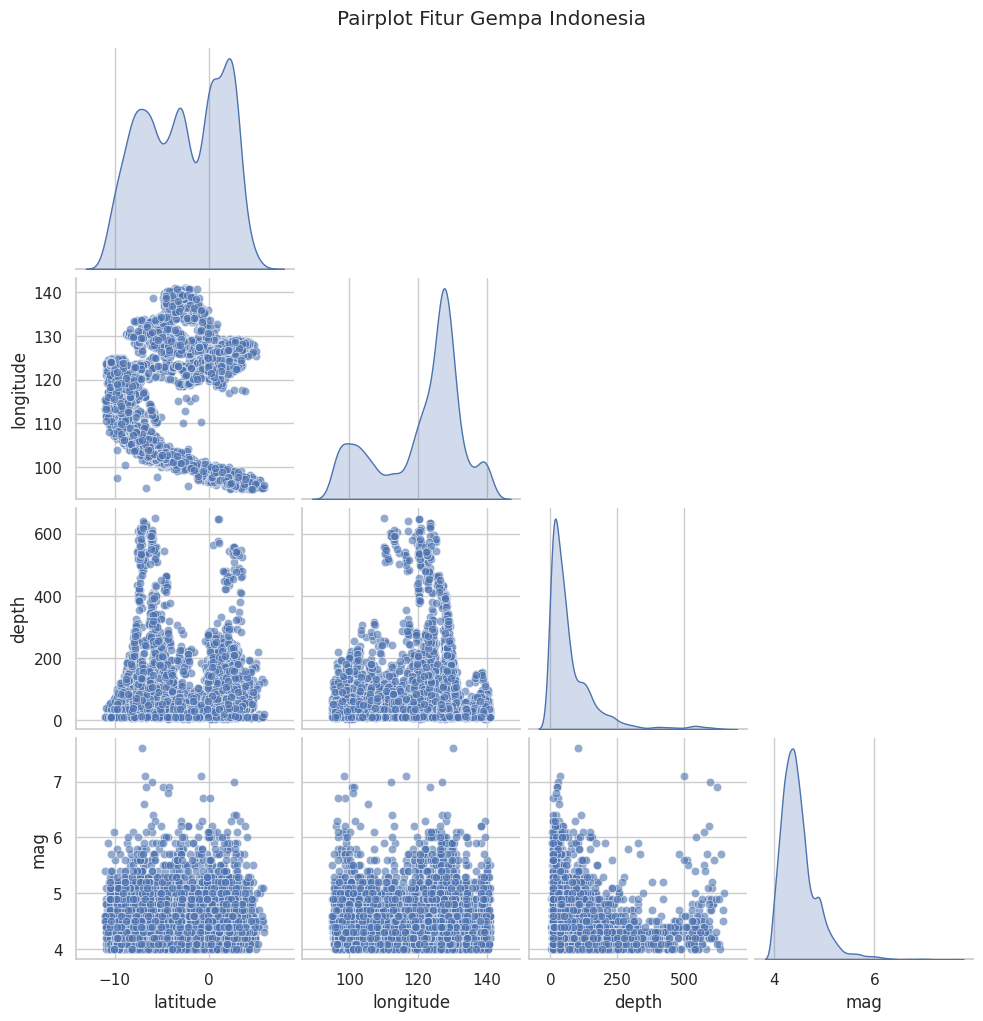

In [4]:
# Pastikan kolom tersedia dan tidak ada missing values
features = ['latitude', 'longitude', 'depth', 'mag']
data_pair = data[features].dropna()

sns.pairplot(data_pair, diag_kind='kde', corner=True, plot_kws={'alpha': 0.6})
plt.suptitle("Pairplot Fitur Gempa Indonesia", y=1.02)
plt.show()

# KORELASI

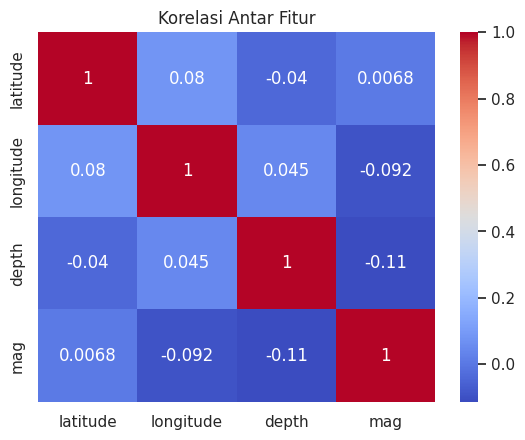

In [5]:
sns.heatmap(data[features].corr(), annot=True, cmap='coolwarm')
plt.title('Korelasi Antar Fitur')
plt.show()

#PREPROCESSING & PCA

In [6]:
features = ['depth', 'mag']
X = data[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

#EVALUASI CLUSTERING FUNCTION

In [7]:
def evaluate_clustering(X_scaled, labels, name):
    if len(set(labels)) > 1:
        s = silhouette_score(X_scaled, labels)
        d = davies_bouldin_score(X_scaled, labels)
        c = calinski_harabasz_score(X_scaled, labels)
        print(f"\n{name} Evaluation:")
        print(f"Silhouette Score        : {s:.4f}")
        print(f"Davies-Bouldin Index    : {d:.4f}")
        print(f"Calinski-Harabasz Score : {c:.4f}")
        return s, d, c
    else:
        print(f"\n{name} menghasilkan hanya 1 cluster atau semua noise.")
        return None, None, None

#CLUSTERING: KMEANS

Evaluasi KMEANS (k = 2 sampai 5):

k=2 | Silhouette: 0.5167 | DB Index: 0.8887 | CH Score: 3977.53
k=3 | Silhouette: 0.4841 | DB Index: 0.7564 | CH Score: 6269.41
k=4 | Silhouette: 0.4651 | DB Index: 0.7377 | CH Score: 6817.11
k=5 | Silhouette: 0.4623 | DB Index: 0.7031 | CH Score: 7207.82


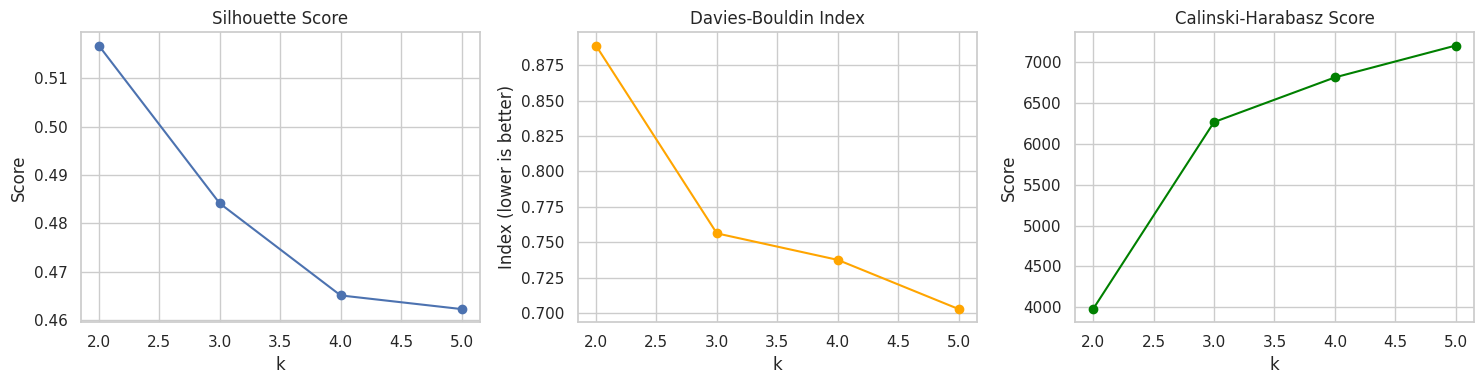

In [8]:
def find_best_k(X_scaled, k_range=range(2, 6)):
    silhouette_scores = []
    davies_bouldin_scores = []
    calinski_scores = []

    print("Evaluasi KMEANS (k = 2 sampai 5):\n")
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_scaled)

        sil_score = silhouette_score(X_scaled, labels)
        db_score = davies_bouldin_score(X_scaled, labels)
        ch_score = calinski_harabasz_score(X_scaled, labels)

        silhouette_scores.append(sil_score)
        davies_bouldin_scores.append(db_score)
        calinski_scores.append(ch_score)

        print(f"k={k} | Silhouette: {sil_score:.4f} | DB Index: {db_score:.4f} | CH Score: {ch_score:.2f}")

    # Visualisasi hasil evaluasi
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.title('Silhouette Score')
    plt.xlabel('k')
    plt.ylabel('Score')

    plt.subplot(1, 3, 2)
    plt.plot(k_range, davies_bouldin_scores, marker='o', color='orange')
    plt.title('Davies-Bouldin Index')
    plt.xlabel('k')
    plt.ylabel('Index (lower is better)')

    plt.subplot(1, 3, 3)
    plt.plot(k_range, calinski_scores, marker='o', color='green')
    plt.title('Calinski-Harabasz Score')
    plt.xlabel('k')
    plt.ylabel('Score')

    plt.tight_layout()
    plt.show()

# Panggil fungsi:
find_best_k(X_scaled, k_range=range(2, 6))

#CLUSTERING: MINIBATCHKMEANS

Evaluasi MiniBatchKMeans (k = 2 sampai 5):

k=2 | Silhouette: 0.5408 | DB Index: 0.8505 | CH Score: 3972.57
k=3 | Silhouette: 0.3167 | DB Index: 0.9904 | CH Score: 3958.79
k=4 | Silhouette: 0.4595 | DB Index: 0.7442 | CH Score: 6748.54
k=5 | Silhouette: 0.4402 | DB Index: 0.8100 | CH Score: 5628.78


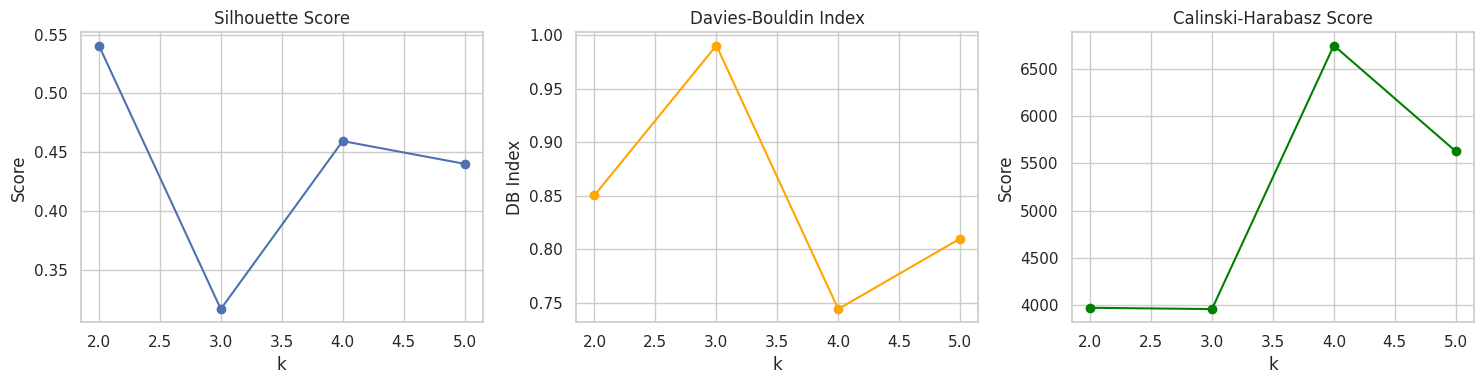

In [9]:
def evaluate_minibatch_kmeans(X_scaled, k_range=range(2, 6)):
    silhouette_scores = []
    db_scores = []
    ch_scores = []

    print("Evaluasi MiniBatchKMeans (k = 2 sampai 5):\n")
    for k in k_range:
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=100)
        labels = kmeans.fit_predict(X_scaled)

        sil = silhouette_score(X_scaled, labels)
        db = davies_bouldin_score(X_scaled, labels)
        ch = calinski_harabasz_score(X_scaled, labels)

        silhouette_scores.append(sil)
        db_scores.append(db)
        ch_scores.append(ch)

        print(f"k={k} | Silhouette: {sil:.4f} | DB Index: {db:.4f} | CH Score: {ch:.2f}")

    # Plot evaluasi
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.title('Silhouette Score')
    plt.xlabel('k')
    plt.ylabel('Score')

    plt.subplot(1, 3, 2)
    plt.plot(k_range, db_scores, marker='o', color='orange')
    plt.title('Davies-Bouldin Index')
    plt.xlabel('k')
    plt.ylabel('DB Index')

    plt.subplot(1, 3, 3)
    plt.plot(k_range, ch_scores, marker='o', color='green')
    plt.title('Calinski-Harabasz Score')
    plt.xlabel('k')
    plt.ylabel('Score')

    plt.tight_layout()
    plt.show()

# Jalankan fungsi
evaluate_minibatch_kmeans(X_scaled)

# CLUSTERING: BIRCH

Evaluasi Birch Clustering (k = 2 sampai 5):

k=2 | Silhouette: 0.7551 | DB Index: 0.7505 | CH Score: 463.61
k=3 | Silhouette: 0.6823 | DB Index: 0.7273 | CH Score: 1735.70
k=4 | Silhouette: 0.6723 | DB Index: 0.4469 | CH Score: 1237.30
k=5 | Silhouette: 0.5451 | DB Index: 0.5795 | CH Score: 1955.72


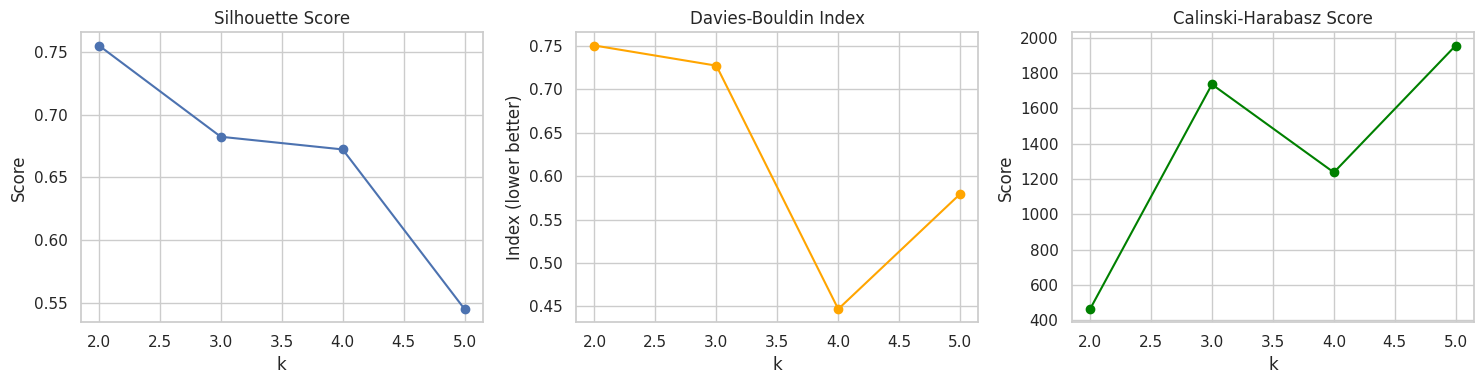

In [10]:
def evaluate_birch_k2_to_k5(X_scaled, k_range=range(2, 6)):
    silhouette_scores = []
    db_scores = []
    ch_scores = []

    print("Evaluasi Birch Clustering (k = 2 sampai 5):\n")
    for k in k_range:
        model = Birch(n_clusters=k)
        labels = model.fit_predict(X_scaled)

        sil = silhouette_score(X_scaled, labels)
        db = davies_bouldin_score(X_scaled, labels)
        ch = calinski_harabasz_score(X_scaled, labels)

        silhouette_scores.append(sil)
        db_scores.append(db)
        ch_scores.append(ch)

        print(f"k={k} | Silhouette: {sil:.4f} | DB Index: {db:.4f} | CH Score: {ch:.2f}")

    # Plot hasil evaluasi
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.title('Silhouette Score')
    plt.xlabel('k')
    plt.ylabel('Score')

    plt.subplot(1, 3, 2)
    plt.plot(k_range, db_scores, marker='o', color='orange')
    plt.title('Davies-Bouldin Index')
    plt.xlabel('k')
    plt.ylabel('Index (lower better)')

    plt.subplot(1, 3, 3)
    plt.plot(k_range, ch_scores, marker='o', color='green')
    plt.title('Calinski-Harabasz Score')
    plt.xlabel('k')
    plt.ylabel('Score')

    plt.tight_layout()
    plt.show()

# Jalankan fungsi
evaluate_birch_k2_to_k5(X_scaled)

# KMEANS DENGAN K=2

In [11]:
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X_scaled)

evaluate_clustering(X_scaled, labels, "KMeans (k=2)")


KMeans (k=2) Evaluation:
Silhouette Score        : 0.5167
Davies-Bouldin Index    : 0.8887
Calinski-Harabasz Score : 3977.5304


(np.float64(0.5167400024830778),
 np.float64(0.8887384935109369),
 np.float64(3977.5303964437776))

# MINIBATCHKMEANS DENGAN K=2

In [12]:
kmeans_mb = MiniBatchKMeans(n_clusters=2, random_state=42, batch_size=100)
labels_mb = kmeans_mb.fit_predict(X_scaled)

evaluate_clustering(X_scaled, labels_mb, "MiniBatchKMeans (k=2)")


MiniBatchKMeans (k=2) Evaluation:
Silhouette Score        : 0.5408
Davies-Bouldin Index    : 0.8505
Calinski-Harabasz Score : 3972.5654


(np.float64(0.5407934141806111),
 np.float64(0.850522996265448),
 np.float64(3972.5654067191635))

# BIRCH DENGAN K=2

In [13]:
birch_model = Birch(n_clusters=2)
labels_birch = birch_model.fit_predict(X_scaled)

evaluate_clustering(X_scaled, labels_birch, "Birch (k=2)")


Birch (k=2) Evaluation:
Silhouette Score        : 0.7551
Davies-Bouldin Index    : 0.7505
Calinski-Harabasz Score : 463.6055


(np.float64(0.7550512425196428),
 np.float64(0.7504847826476881),
 np.float64(463.6054885934887))

# JUMLAH DATA PER CLUSTER (K=2)

In [14]:
print(f"\n📊 Jumlah Data per Cluster (k=2)\n{'-'*35}")
print("KMeans:")
for i, count in enumerate(np.bincount(labels)):
    print(f"  Cluster {i}: {count} data")

print("\nMiniBatchKMeans:")
for i, count in enumerate(np.bincount(labels_mb)):
    print(f"  Cluster {i}: {count} data")

print("\nBirch:")
for i, count in enumerate(np.bincount(labels_birch)):
    print(f"  Cluster {i}: {count} data")


📊 Jumlah Data per Cluster (k=2)
-----------------------------------
KMeans:
  Cluster 0: 7229 data
  Cluster 1: 1033 data

MiniBatchKMeans:
  Cluster 0: 7389 data
  Cluster 1: 873 data

Birch:
  Cluster 0: 8235 data
  Cluster 1: 27 data


# VISUALISASI PCA

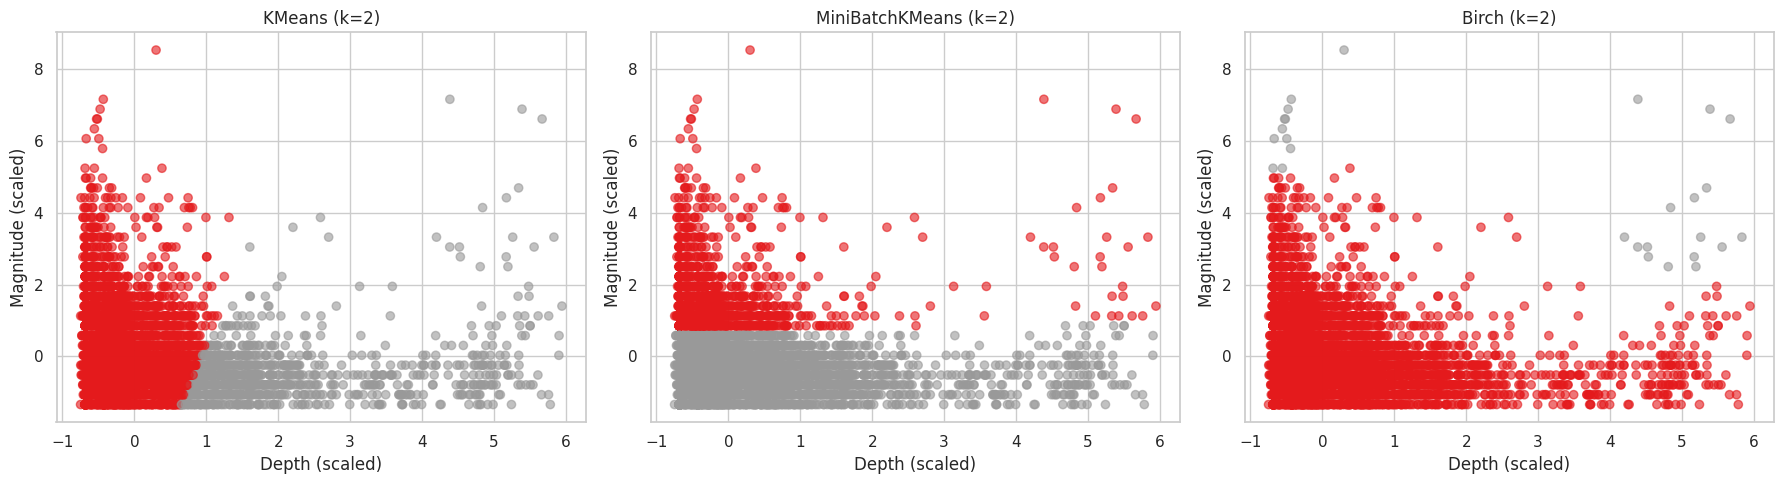

In [15]:
# Model clustering
models = {
    "KMeans (k=2)": KMeans(n_clusters=2, random_state=42),
    "MiniBatchKMeans (k=2)": MiniBatchKMeans(n_clusters=2, random_state=42),
    "Birch (k=2)": Birch(n_clusters=2)
}

# Plot hasil clustering 2D
plt.figure(figsize=(18, 5))

for i, (name, model) in enumerate(models.items()):
    labels = model.fit_predict(X_scaled)

    plt.subplot(1, 3, i + 1)
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='Set1', alpha=0.6)
    plt.title(name)
    plt.xlabel('Depth (scaled)')
    plt.ylabel('Magnitude (scaled)')
    plt.grid(True)

plt.tight_layout()
plt.show()

#VISUALISASI MAPPING

In [16]:
# Simpan label dari masing-masing model
labels_kmeans = kmeans.fit_predict(X_scaled)
labels_minibatch = kmeans_mb.fit_predict(X_scaled)
labels_birch = birch_model.fit_predict(X_scaled)

In [17]:
risk_label = {0: 'Tidak Rawan', 1: 'Sangat Rawan'}
risk_color = {'Tidak Rawan': 'green', 'Sangat Rawan': 'red'}

# KMeans
data['Cluster_KMeans'] = labels_kmeans
kmeans_mean = data.groupby('Cluster_KMeans')['mag'].mean().sort_values()
kmeans_map = {cluster: i for i, cluster in enumerate(kmeans_mean.index)}
data['Risk_KMeans'] = data['Cluster_KMeans'].map(kmeans_map).map(risk_label)

# MiniBatch
data['Cluster_MB'] = labels_minibatch
mb_mean = data.groupby('Cluster_MB')['mag'].mean().sort_values()
mb_map = {cluster: i for i, cluster in enumerate(mb_mean.index)}
data['Risk_MB'] = data['Cluster_MB'].map(mb_map).map(risk_label)

# Birch
data['Cluster_Birch'] = labels_birch
birch_mean = data.groupby('Cluster_Birch')['mag'].mean().sort_values()
birch_map = {cluster: i for i, cluster in enumerate(birch_mean.index)}
data['Risk_Birch'] = data['Cluster_Birch'].map(birch_map).map(risk_label)

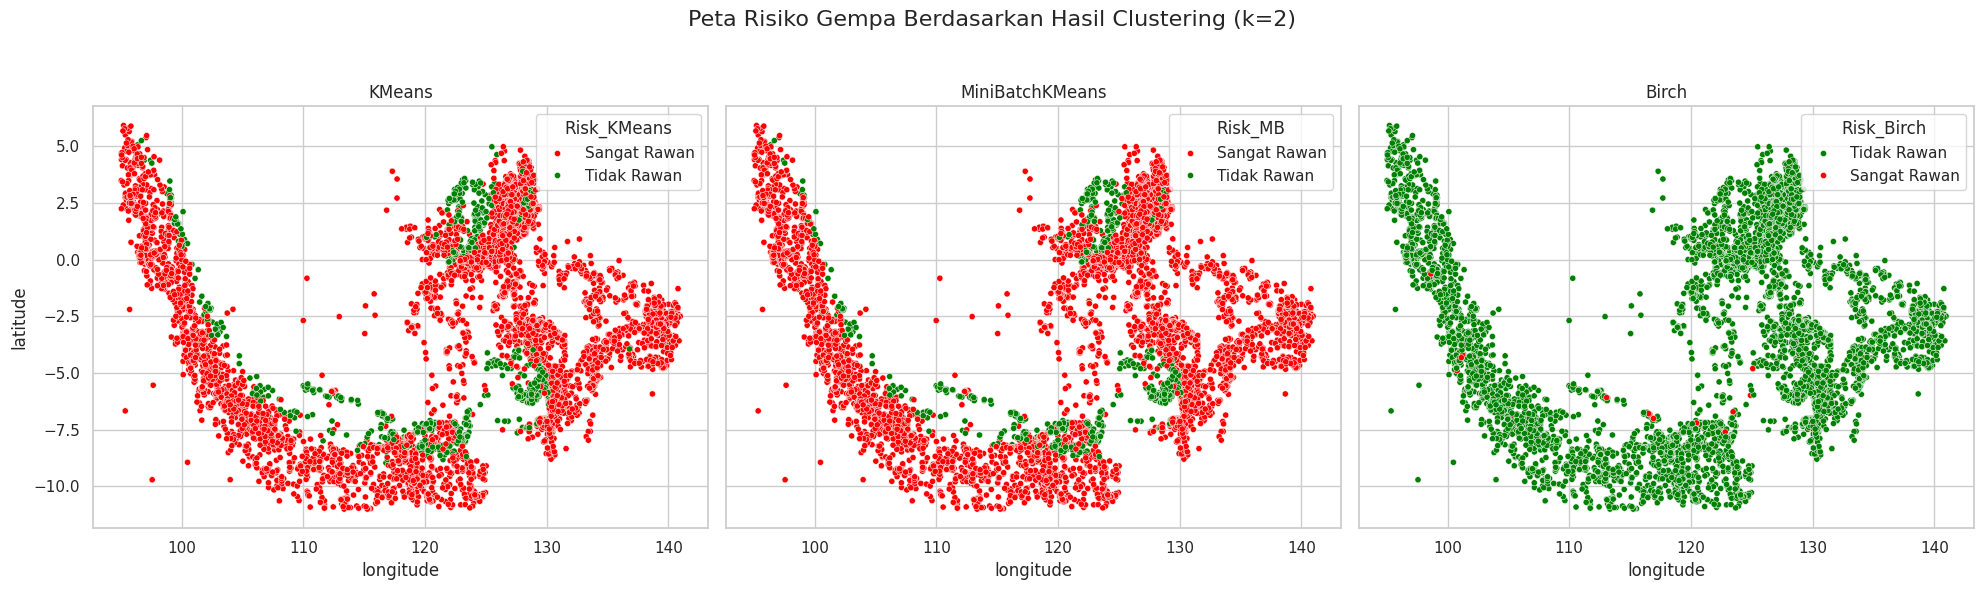

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)

# KMeans
sns.scatterplot(data=data, x='longitude', y='latitude', hue='Risk_KMeans', palette=risk_color, s=20, ax=axes[0])
axes[0].set_title("KMeans")
axes[0].grid(True)

# MiniBatch
sns.scatterplot(data=data, x='longitude', y='latitude', hue='Risk_MB', palette=risk_color, s=20, ax=axes[1])
axes[1].set_title("MiniBatchKMeans")
axes[1].grid(True)

# Birch
sns.scatterplot(data=data, x='longitude', y='latitude', hue='Risk_Birch', palette=risk_color, s=20, ax=axes[2])
axes[2].set_title("Birch")
axes[2].grid(True)

plt.suptitle("Peta Risiko Gempa Berdasarkan Hasil Clustering (k=2)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()